In [13]:
!pip install pmdarima prophet tensorflow --quiet

In [3]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

In [4]:
#loading dataset
df = pd.read_csv('/content/walmart.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,25-08-1972,0.021159,0.021566,0.021159,0.021484,0.011639,7526400
1,28-08-1972,0.021484,0.021647,0.021403,0.021403,0.011595,2918400
2,29-08-1972,0.021322,0.021322,0.021159,0.021159,0.011463,5836800
3,30-08-1972,0.021159,0.021159,0.020996,0.021159,0.011463,1228800
4,31-08-1972,0.020996,0.020996,0.020833,0.020833,0.011286,2611200


In [5]:
print(df.info)
print(df.isnull().sum())

<bound method DataFrame.info of              Date       Open       High        Low      Close  Adj Close  \
0      25-08-1972   0.021159   0.021566   0.021159   0.021484   0.011639   
1      28-08-1972   0.021484   0.021647   0.021403   0.021403   0.011595   
2      29-08-1972   0.021322   0.021322   0.021159   0.021159   0.011463   
3      30-08-1972   0.021159   0.021159   0.020996   0.021159   0.011463   
4      31-08-1972   0.020996   0.020996   0.020833   0.020833   0.011286   
...           ...        ...        ...        ...        ...        ...   
13213  24-01-2025  93.540001  95.010002  93.459999  94.760002  94.760002   
13214  27-01-2025  95.900002  97.459999  94.820000  97.400002  97.400002   
13215  28-01-2025  97.230003  97.839996  96.730003  97.290001  97.290001   
13216  29-01-2025  97.430000  98.169998  97.220001  97.500000  97.500000   
13217  30-01-2025  97.690002  98.930000  97.419998  98.650002  98.650002   

         Volume  
0       7526400  
1       2918400  
2

In [6]:
# Display exact column names with spaces visible
print(list(df.columns))


['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [7]:
# Create synthetic date index
df['Date'] = pd.date_range(start='2010-01-01', periods=len(df), freq='D')

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Check
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,0.021159,0.021566,0.021159,0.021484,0.011639,7526400
2010-01-02,0.021484,0.021647,0.021403,0.021403,0.011595,2918400
2010-01-03,0.021322,0.021322,0.021159,0.021159,0.011463,5836800
2010-01-04,0.021159,0.021159,0.020996,0.021159,0.011463,1228800
2010-01-05,0.020996,0.020996,0.020833,0.020833,0.011286,2611200


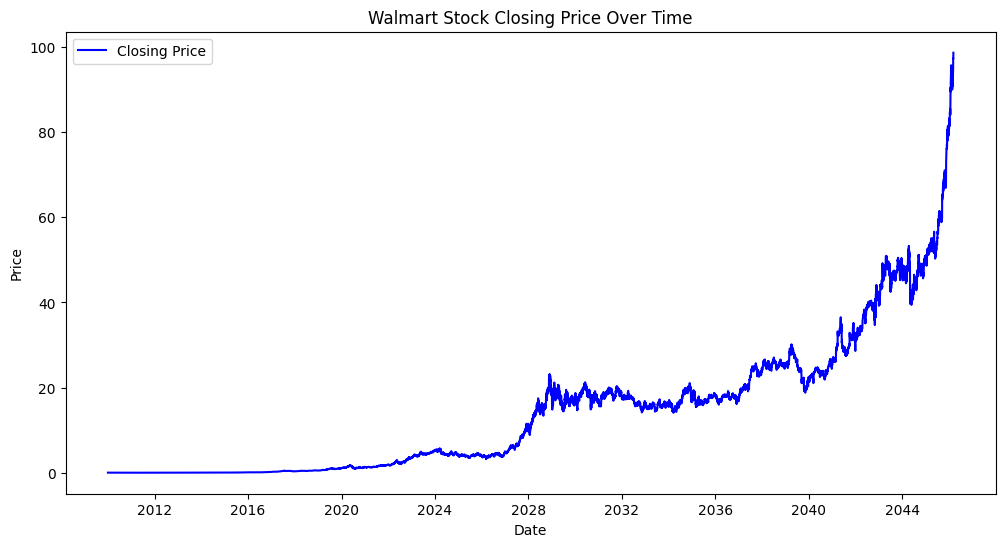

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.title('Walmart Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Check stationarity properly
if result[1] <= 0.05:
    print("✅ Data is stationary.")
else:
    print("⚠️ Data is NOT stationary. Differencing is needed.")


ADF Statistic: 6.393236184270932
p-value: 1.0
⚠️ Data is NOT stationary. Differencing is needed.


In [10]:
# First-order differencing
df_diff = df['Close'].diff().dropna()

# ADF test after differencing
result = adfuller(df_diff)
print('ADF Statistic after differencing:', result[0])
print('p-value after differencing:', result[1])

if result[1] <= 0.05:
    print("✅ Data is now stationary after differencing.")
else:
    print("⚠️ Data is still NOT stationary. Consider additional differencing.")


ADF Statistic after differencing: -18.669980377581965
p-value after differencing: 2.0449781860507065e-30
✅ Data is now stationary after differencing.


In [15]:
# Split data (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]


In [16]:
from statsmodels.tsa.arima.model import ARIMA

# Use (p=1, d=1, q=1) as a simple starting point
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))


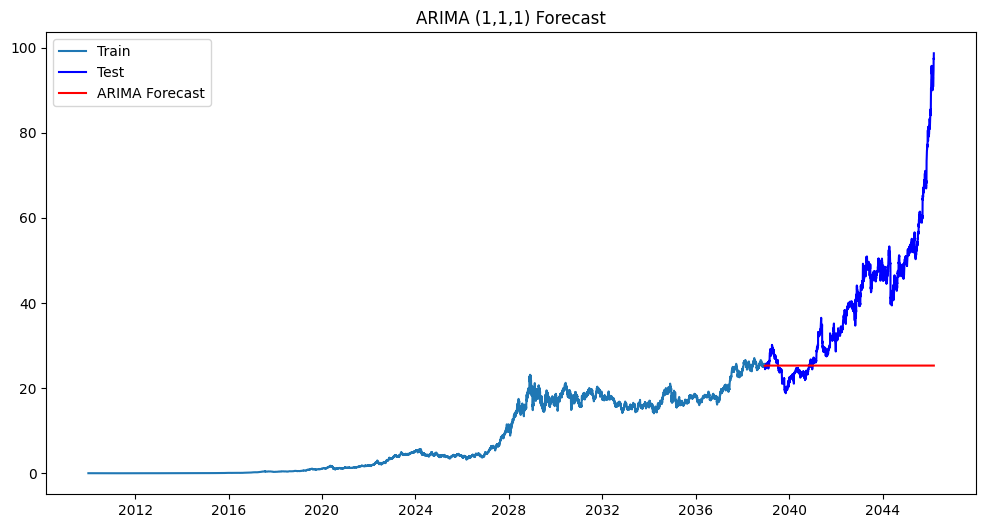

In [17]:
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='blue')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA (1,1,1) Forecast')
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

rmse = sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast) * 100

print('ARIMA RMSE:', rmse)
print('ARIMA MAPE:', mape)


ARIMA RMSE: 21.00614400983332
ARIMA MAPE: 31.4174020399912


In [19]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = df[['Close']].reset_index()
prophet_data.columns = ['ds', 'y']

prophet_data.head()


,ds,y
0,2010-01-01,0.021484
1,2010-01-02,0.021403
2,2010-01-03,0.021159
3,2010-01-04,0.021159
4,2010-01-05,0.020833


In [22]:
# 80% train, 20% test
train_size = int(len(prophet_data) * 0.8)
train_df = prophet_data[:train_size]
test_df = prophet_data[train_size:]


In [23]:
model = Prophet()
model.fit(train_df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6fgi4wow/_dy5qu6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6fgi4wow/vp3szllh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77364', 'data', 'file=/tmp/tmp6fgi4wow/_dy5qu6f.json', 'init=/tmp/tmp6fgi4wow/vp3szllh.json', 'output', 'file=/tmp/tmp6fgi4wow/prophet_model4fspfy19/prophet_model-20250719152601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:26:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:26:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [25]:
# Create future dataframe
future = model.make_future_dataframe(periods=len(test_df))

# Forecast
forecast = model.predict(future)

# Show forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
13213,2046-03-06,37.445392,13.347924,61.201279
13214,2046-03-07,37.457530,13.570078,61.804917
13215,2046-03-08,37.463490,12.911005,61.573490
13216,2046-03-09,37.476942,13.261067,61.781446
13217,2046-03-10,37.476853,13.324303,61.654097


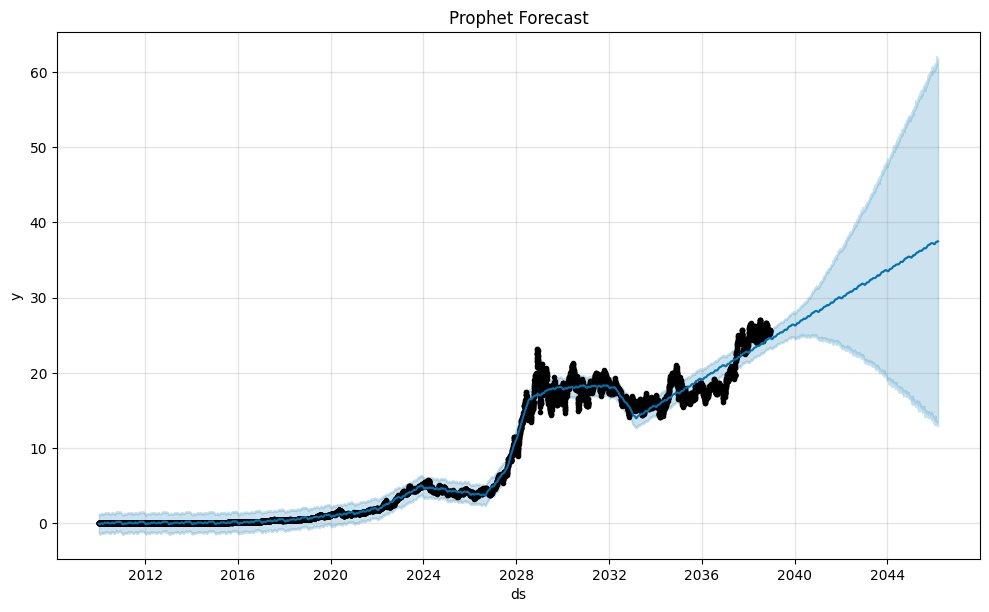

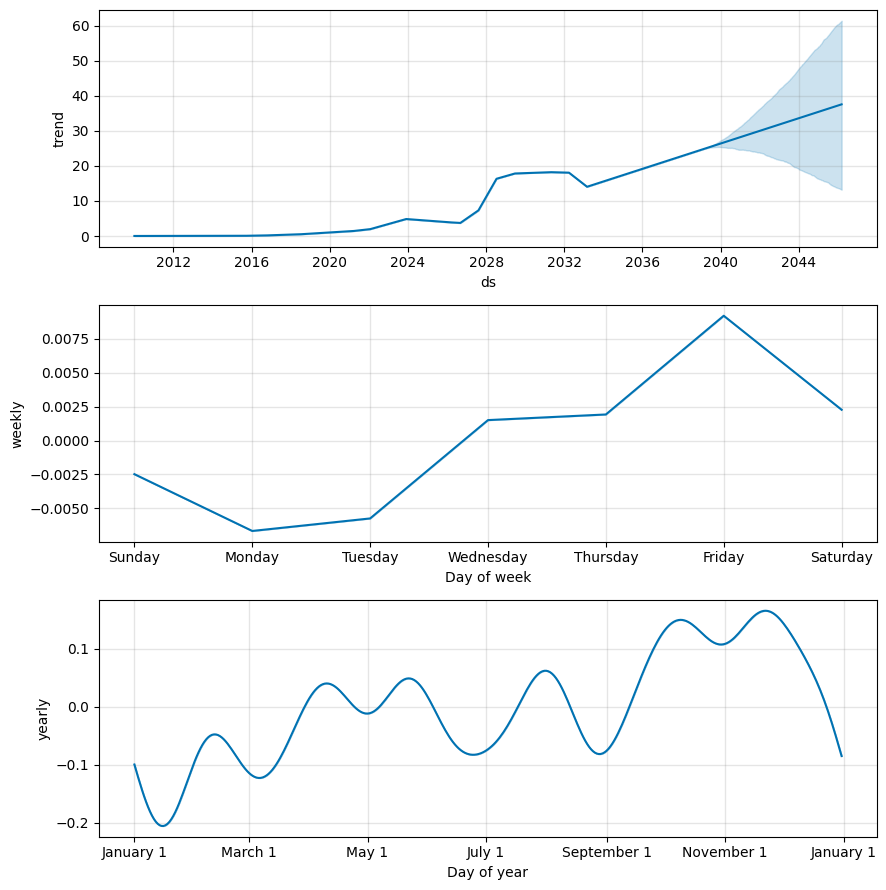

In [28]:
model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

model.plot_components(forecast)
plt.show()


In [29]:
# Use only test period for evaluation
predicted = forecast.iloc[-len(test_df):]['yhat']
actual = test_df['y']

# RMSE & MAPE
rmse = sqrt(mean_squared_error(actual, predicted))
mape = mean_absolute_percentage_error(actual, predicted) * 100

print('Prophet RMSE:', rmse)
print('Prophet MAPE:', mape)


Prophet RMSE: 14.811261522302068
Prophet MAPE: 21.568406218510745


In [30]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


In [32]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(np.array(df['Close']).reshape(-1,1))


In [34]:
# Function to create dataset
def create_dataset(data, n_steps=30):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_steps = 30
X, y = create_dataset(scaled_close, n_steps)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [36]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


In [39]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 0.0011 - val_loss: 4.9306e-04
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 1.9281e-05 - val_loss: 3.7838e-04
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 1.7390e-05 - val_loss: 4.5182e-04
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 1.4852e-05 - val_loss: 3.2662e-04
Epoch 5/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 1.5537e-05 - val_loss: 3.0315e-04
Epoch 6/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 1.3005e-05 - val_loss: 2.4466e-04
Epoch 7/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 1.1627e-05 - val_loss: 2.7404e-04
Epoch 8/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 1.1477e-05 - val_loss: 1.2193e-04
Epoch 9/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 1.1230e-05 - val_loss: 1.6645e-04
Epoch 10/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 9.6331e-06 - val_loss: 1.4107e-04
Epoch 11/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 21

In [40]:
# Predict on test data
y_pred = model.predict(X_test)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [42]:
# Reshape for inverse transform
y_test_scaled = y_test.reshape(-1, 1)
y_pred_scaled = y_pred.reshape(-1, 1)

# Inverse transform to get real prices
y_test_real = scaler.inverse_transform(y_test_scaled)
y_pred_real = scaler.inverse_transform(y_pred_scaled)


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_test_real, y_pred_real))
mape = mean_absolute_percentage_error(y_test_real, y_pred_real) * 100

print('LSTM RMSE:', rmse)
print('LSTM MAPE:', mape)


LSTM RMSE: 0.8535189519122548
LSTM MAPE: 1.2456644276002709


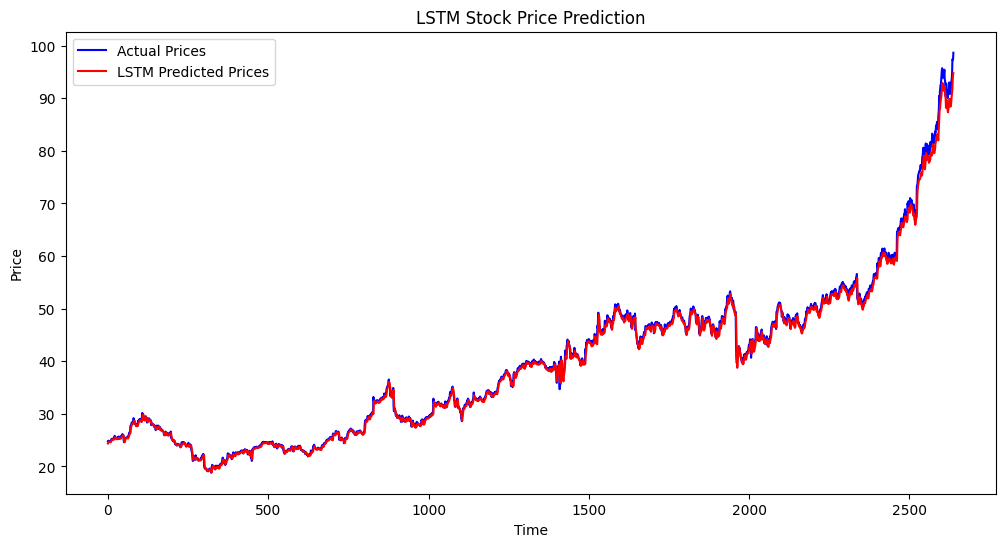

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Actual Prices', color='blue')
plt.plot(y_pred_real, label='LSTM Predicted Prices', color='red')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
